# Phase II - Preprocessing and Supervised Learning with CERT Dataset

## A. Preprocessing and Exploratory Analysis

In [1]:
#Load necessary libraries.
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions as F
from pyspark.sql.types import TimestampType
from pyspark.sql.types import StringType
from pyspark.sql.functions import *
from pyspark_dist_explore import hist
from handyspark import *
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
#Load Spark Context and print it.
sc = SparkContext()
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [3]:
#Create SQL Context
spark = SparkSession.builder.getOrCreate
sqlContext = SQLContext(sc)

In [4]:
#Load the true positives data.
true_positives = "Documents/CERT_DATA/answers/insiders.csv"
true_positives_dfs = sqlContext.read.format('com.databricks.spark.csv').options(header='true').load(true_positives)
true_positives_dfs.show()

+-------+--------+------------------+-------+-------------------+-------------------+
|dataset|scenario|           details|   user|              start|                end|
+-------+--------+------------------+-------+-------------------+-------------------+
|      2|       1|            r2.csv|ONS0995|   3/6/2010 1:41:56|  3/20/2010 8:10:12|
|    3.1|       1|        r3.1-1.csv|CSF0929|07/01/2010 01:24:58|07/16/2010 06:52:00|
|    3.1|       2|        r3.1-2.csv|CCH0959|08/02/2010 10:34:31|09/30/2010 15:04:03|
|    3.2|       1|        r3.2-1.csv|RCW0822|09/29/2010 21:10:27|10/15/2010 06:34:52|
|    3.2|       2|        r3.2-2.csv|JCE0258|07/12/2010 08:16:02|09/03/2010 16:16:29|
|    4.1|       1|        r4.1-1.csv|ABB0427|08/21/2010 05:20:34|08/27/2010 05:39:51|
|    4.1|       2|        r4.1-2.csv|HFC0492|08/23/2010 10:40:56|10/14/2010 17:11:42|
|    4.1|       3|        r4.1-3.csv|KTW0365|07/08/2010 11:51:00|07/09/2010 20:54:16|
|    4.2|       1|r4.2-1-AAM0658.csv|AAM0658|10/23/201

I will only sample scenario 2 described in scenarios.csv as:
"User begins surfing job websites and soliciting employment from a competitor. Before leaving the company, they use a thumb drive (at markedly higher rates than their previous activity) to steal data."

In [5]:
#Filter out the rows and columns I am interested in.
true_positives_dfs = true_positives_dfs.select('scenario','details').orderBy(true_positives_dfs.details)
true_positives_dfs_2 = true_positives_dfs.filter(true_positives_dfs.scenario == 2)
true_positives_dfs_2.show()

+--------+------------------+
|scenario|           details|
+--------+------------------+
|       2|        r3.1-2.csv|
|       2|        r3.2-2.csv|
|       2|        r4.1-2.csv|
|       2|r4.2-2-AAF0535.csv|
|       2|r4.2-2-ABC0174.csv|
|       2|r4.2-2-AKR0057.csv|
|       2|r4.2-2-CCL0068.csv|
|       2|r4.2-2-CEJ0109.csv|
|       2|r4.2-2-CQW0652.csv|
|       2|r4.2-2-DIB0285.csv|
|       2|r4.2-2-DRR0162.csv|
|       2|r4.2-2-EDB0714.csv|
|       2|r4.2-2-EGD0132.csv|
|       2|r4.2-2-FSC0601.csv|
|       2|r4.2-2-HBO0413.csv|
|       2|r4.2-2-HXL0968.csv|
|       2|r4.2-2-IJM0776.csv|
|       2|r4.2-2-IKR0401.csv|
|       2|r4.2-2-IUB0565.csv|
|       2|r4.2-2-JJM0203.csv|
+--------+------------------+
only showing top 20 rows



In [6]:
#Generate a linux script to combine true positives for scenario 2 to avoid having to manually type it.
files_2 = true_positives_dfs_2.select(F.col('details')).toPandas()
files_list = files_2['details'].tolist()

string = "cat"
for file in files_list:
    string = string + " " + file
print(string + '> scenario_2.csv')

cat r3.1-2.csv r3.2-2.csv r4.1-2.csv r4.2-2-AAF0535.csv r4.2-2-ABC0174.csv r4.2-2-AKR0057.csv r4.2-2-CCL0068.csv r4.2-2-CEJ0109.csv r4.2-2-CQW0652.csv r4.2-2-DIB0285.csv r4.2-2-DRR0162.csv r4.2-2-EDB0714.csv r4.2-2-EGD0132.csv r4.2-2-FSC0601.csv r4.2-2-HBO0413.csv r4.2-2-HXL0968.csv r4.2-2-IJM0776.csv r4.2-2-IKR0401.csv r4.2-2-IUB0565.csv r4.2-2-JJM0203.csv r4.2-2-KRL0501.csv r4.2-2-LCC0819.csv r4.2-2-MDH0580.csv r4.2-2-MOS0047.csv r4.2-2-NWT0098.csv r4.2-2-PNL0301.csv r4.2-2-PSF0133.csv r4.2-2-RAR0725.csv r4.2-2-RHL0992.csv r4.2-2-RMW0542.csv r4.2-2-TNM0961.csv r4.2-2-VSS0154.csv r4.2-2-XHW0498.csv r5.1-2.csv r5.2-2-BYO1846.csv r5.2-2-CHP1711.csv r5.2-2-CIF1430.csv r5.2-2-CKP0630.csv r5.2-2-DCC1119.csv r5.2-2-GWG0497.csv r5.2-2-HIS1394.csv r5.2-2-HMS1658.csv r5.2-2-HSN0675.csv r5.2-2-HXP0976.csv r5.2-2-ICB1354.csv r5.2-2-ITA0159.csv r5.2-2-JAL0811.csv r5.2-2-KSS1005.csv r5.2-2-LVF1626.csv r5.2-2-MCP0611.csv r5.2-2-MDS0680.csv r5.2-2-MGB1235.csv r5.2-2-NAH1366.csv r5.2-2-OKM1092.csv r5

Next I created a subset of true negativves that is approximately equal to true positive set.
I then merged both sets in a linux shell using the script above, added a label column and encoded categorical values.

In [7]:
#Next step is to create a DataFrame out of the resulting set and perforn some data wrangling.
df_all = sqlContext.read.format('com.databricks.spark.csv').options(header='true').load('Documents/CERT_DATA/r5.2/all_reduced.csv')
df_all.show()

+------+-------+--------------------+-------------------+-------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----+----+----+----+----+----+----+
|vector|insider|                  id|               date|   user| source|              action|                  cc|                 bcc|                from|            activity|                size|         attachments|             content|                _c14|                _c15|                _c16|_c17|_c18|_c19|_c20|_c21|_c22|_c23|
+------+-------+--------------------+-------------------+-------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----+----+----+-

In [8]:
#Make it more easy to look at with Pandas.
pd_df_all = df_all.toPandas()
pd_df_all.head()

,vector,insider,id,date,user,source,action,cc,bcc,from,...,_c14,_c15,_c16,_c17,_c18,_c19,_c20,_c21,_c22,_c23
0,email,0,{N9X0-P3SX99UT-3623QQUN},01/02/2010 06:49:35,KMC1934,PC-2683,Harding.Alden.Lester@dtaa.com,Ora.Clementine.Lester@dtaa.com,Remedios.Kylynn.Weaver@dtaa.com,Hamilton.Palmer.Cortez@dtaa.com,...,None,lost six speculated individual theoren in onta...,None,None,None,None,None,None,None,None
1,email,0,{F5G8-U4KL36AB-1579CZGX},01/02/2010 06:50:35,KMC1934,PC-2683,Harding.Alden.Lester@dtaa.com,Ora.Clementine.Lester@dtaa.com,Remedios.Kylynn.Weaver@dtaa.com,Hamilton.Palmer.Cortez@dtaa.com,...,None,lost six speculated individual theoren in onta...,None,None,None,None,None,None,None,None
2,email,0,{U8D2-M5FH65BW-3939CQIC},01/02/2010 06:53:37,KMC1934,PC-2683,Griffith.Xenos.Miles@dtaa.com,Karina.Melanie.Collins@dtaa.com,None,Karina.Melanie.Collins@dtaa.com,...,None,None,None,None,None,None,None,None,None,None
3,email,0,{A5X6-X3KN62LU-5816QTBZ},01/02/2010 06:53:46,KMC1934,PC-2683,Mechelle.Nicole.Miles@dtaa.com,None,Karina.Melanie.Collins@dtaa.com,Karina.Melanie.Collins@dtaa.com,...,None,None,None,None,None,None,None,None,None,None
4,email,0,{Q8R5-A2WJ20NG-9108MVZX},01/02/2010 06:54:33,KMC1934,PC-2683,Mechelle.Nicole.Miles@dtaa.com,Karina.Melanie.Collins@dtaa.com,None,Karina.Melanie.Collins@dtaa.com,...,athlete.doc(774956),sixth former speed athlete annual automotive s...,None,None,None,None,None,None,None,None


In [9]:
#Check out the schema
df_all.printSchema()

root
 |-- vector: string (nullable = true)
 |-- insider: string (nullable = true)
 |-- id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- user: string (nullable = true)
 |-- source: string (nullable = true)
 |-- action: string (nullable = true)
 |-- cc: string (nullable = true)
 |-- bcc: string (nullable = true)
 |-- from: string (nullable = true)
 |-- activity: string (nullable = true)
 |-- size: string (nullable = true)
 |-- attachments: string (nullable = true)
 |-- content: string (nullable = true)
 |-- _c14: string (nullable = true)
 |-- _c15: string (nullable = true)
 |-- _c16: string (nullable = true)
 |-- _c17: string (nullable = true)
 |-- _c18: string (nullable = true)
 |-- _c19: string (nullable = true)
 |-- _c20: string (nullable = true)
 |-- _c21: string (nullable = true)
 |-- _c22: string (nullable = true)
 |-- _c23: string (nullable = true)



In [10]:
#First, encode categorical columns and convert date to a timestamp format
df_all = df_all.withColumn('vector', translate('vector', 'http', '0'))
df_all = df_all.withColumn('vector', translate('vector', 'email', '1'))
df_all = df_all.withColumn('vector', translate('vector', 'device', '2'))
df_all = df_all.withColumn('vector', df_all.vector.cast('integer'))
df_all = df_all.withColumn('insider', df_all.insider.cast('integer'))
df_all = df_all.withColumn('date', from_unixtime(unix_timestamp('date', 'MM/dd/yyy hh:mm:ss')).cast(TimestampType()))

#Next get rid of miscellaneous columns and check out the result and schema
df_all_reduced = df_all.select('vector', 'insider', 'id', 'date', 'user', 'source', 'action')
df_all_reduced.show()
df_all_reduced.printSchema()

+------+-------+--------------------+-------------------+-------+-------+--------------------+
|vector|insider|                  id|               date|   user| source|              action|
+------+-------+--------------------+-------------------+-------+-------+--------------------+
|     1|      0|{N9X0-P3SX99UT-36...|2010-01-02 06:49:35|KMC1934|PC-2683|Harding.Alden.Les...|
|     1|      0|{F5G8-U4KL36AB-15...|2010-01-02 06:50:35|KMC1934|PC-2683|Harding.Alden.Les...|
|     1|      0|{U8D2-M5FH65BW-39...|2010-01-02 06:53:37|KMC1934|PC-2683|Griffith.Xenos.Mi...|
|     1|      0|{A5X6-X3KN62LU-58...|2010-01-02 06:53:46|KMC1934|PC-2683|Mechelle.Nicole.M...|
|     1|      0|{Q8R5-A2WJ20NG-91...|2010-01-02 06:54:33|KMC1934|PC-2683|Mechelle.Nicole.M...|
|     1|      0|{H6Z8-D4DO31VN-19...|2010-01-02 06:54:37|KMC1934|PC-2683|Griffith.Xenos.Mi...|
|     1|      0|{S6S2-U4KM07MU-04...|2010-01-02 06:54:46|KMC1934|PC-2683|Mechelle.Nicole.M...|
|     1|      0|{D5Y7-N8WT17RZ-69...|2010-01-02 06

In [11]:
#Make it pretty with Pandas
pd_df_all_reduced = df_all_reduced.toPandas()
pd_df_all_reduced.head()

,vector,insider,id,date,user,source,action
0,1,0,{N9X0-P3SX99UT-3623QQUN},2010-01-02 06:49:35,KMC1934,PC-2683,Harding.Alden.Lester@dtaa.com
1,1,0,{F5G8-U4KL36AB-1579CZGX},2010-01-02 06:50:35,KMC1934,PC-2683,Harding.Alden.Lester@dtaa.com
2,1,0,{U8D2-M5FH65BW-3939CQIC},2010-01-02 06:53:37,KMC1934,PC-2683,Griffith.Xenos.Miles@dtaa.com
3,1,0,{A5X6-X3KN62LU-5816QTBZ},2010-01-02 06:53:46,KMC1934,PC-2683,Mechelle.Nicole.Miles@dtaa.com
4,1,0,{Q8R5-A2WJ20NG-9108MVZX},2010-01-02 06:54:33,KMC1934,PC-2683,Mechelle.Nicole.Miles@dtaa.com


In [12]:
#Encode the remaining categorical columns in Pandas
pd_df_all_reduced["user"] = pd_df_all_reduced["user"].astype('category')
pd_df_all_reduced["source"] = pd_df_all_reduced["source"].astype('category')
pd_df_all_reduced["action"] = pd_df_all_reduced["action"].astype('category')
pd_df_all_reduced["user_cat"] = pd_df_all_reduced["user"].cat.codes
pd_df_all_reduced["source_cat"] = pd_df_all_reduced["source"].cat.codes
pd_df_all_reduced["action_cat"] = pd_df_all_reduced["action"].cat.codes
pd_df_all_reduced.head()

,vector,insider,id,date,user,source,action,user_cat,source_cat,action_cat
0,1,0,{N9X0-P3SX99UT-3623QQUN},2010-01-02 06:49:35,KMC1934,PC-2683,Harding.Alden.Lester@dtaa.com,432,219,541
1,1,0,{F5G8-U4KL36AB-1579CZGX},2010-01-02 06:50:35,KMC1934,PC-2683,Harding.Alden.Lester@dtaa.com,432,219,541
2,1,0,{U8D2-M5FH65BW-3939CQIC},2010-01-02 06:53:37,KMC1934,PC-2683,Griffith.Xenos.Miles@dtaa.com,432,219,513
3,1,0,{A5X6-X3KN62LU-5816QTBZ},2010-01-02 06:53:46,KMC1934,PC-2683,Mechelle.Nicole.Miles@dtaa.com,432,219,920
4,1,0,{Q8R5-A2WJ20NG-9108MVZX},2010-01-02 06:54:33,KMC1934,PC-2683,Mechelle.Nicole.Miles@dtaa.com,432,219,920


In [13]:
#Check out schema
pd_df_all_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29399 entries, 0 to 29398
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   vector      29399 non-null  int32         
 1   insider     29399 non-null  int32         
 2   id          29399 non-null  object        
 3   date        18306 non-null  datetime64[ns]
 4   user        29399 non-null  category      
 5   source      29399 non-null  category      
 6   action      25715 non-null  category      
 7   user_cat    29399 non-null  int16         
 8   source_cat  29399 non-null  int16         
 9   action_cat  29399 non-null  int16         
dtypes: category(3), datetime64[ns](1), int16(3), int32(2), object(1)
memory usage: 1.2+ MB


In [14]:
#Replace original columns with the categorical ones and convert timestamp to epoch.
del pd_df_all_reduced["user"]
del pd_df_all_reduced["source"]
del pd_df_all_reduced["action"]
pd_df_all_reduced.rename(columns={"user_cat": "user", "source_cat": "source", "action_cat": "action"}, inplace=True)
pd_df_all_reduced['date'] = pd.to_datetime(pd_df_all_reduced['date']).values.astype(np.int64) // 10 ** 6
pd_df_all_reduced.head()

,vector,insider,id,date,user,source,action
0,1,0,{N9X0-P3SX99UT-3623QQUN},1262414975000,432,219,541
1,1,0,{F5G8-U4KL36AB-1579CZGX},1262415035000,432,219,541
2,1,0,{U8D2-M5FH65BW-3939CQIC},1262415217000,432,219,513
3,1,0,{A5X6-X3KN62LU-5816QTBZ},1262415226000,432,219,920
4,1,0,{Q8R5-A2WJ20NG-9108MVZX},1262415273000,432,219,920


In [15]:
#Shorten the name for simplicity and check out the schema again
df = pd_df_all_reduced
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29399 entries, 0 to 29398
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   vector   29399 non-null  int32 
 1   insider  29399 non-null  int32 
 2   id       29399 non-null  object
 3   date     29399 non-null  int64 
 4   user     29399 non-null  int16 
 5   source   29399 non-null  int16 
 6   action   29399 non-null  int16 
dtypes: int16(3), int32(2), int64(1), object(1)
memory usage: 861.4+ KB


## B. Deep Learning with Tensorflow

In [16]:
#Split the data into train and test and observe the breakdown.
train, test = train_test_split(df, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

18815 train examples
4704 validation examples
5880 test examples


In [17]:
#Create custom function to prepare data for Tensorflow
def df_to_dataset(df, shuffle=True, batch_size=32):
  df = df.copy()
  labels = df.pop('insider')
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(df))
  ds = ds.batch(batch_size)
  return ds

In [18]:
#Slect Columns
feature_columns = []
for header in ["vector", "date", "user", "source", "action"]:
    feature_columns.append(feature_column.numeric_column(header))
#Create feature layer
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)
#Set batch size pipeline
batch_size = 32
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)
#Create compile and train model
model = tf.keras.Sequential([
    feature_layer,layers.Dense(128, activation='relu'),layers.Dense(128, activation='relu'),layers.Dense(1)
])
model.compile(optimizer='adam',loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'])
model.fit(train_ds,validation_data=val_ds,epochs=5)
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

Epoch 1/5
588/588 [==============================] - 3s 5ms/step - loss: 10453292032.0000 - accuracy: 0.5217 - val_loss: 10630901760.0000 - val_accuracy: 0.4109
Epoch 2/5
588/588 [==============================] - 3s 4ms/step - loss: 7694547456.0000 - accuracy: 0.5203 - val_loss: 3853362176.0000 - val_accuracy: 0.4109
Epoch 3/5
588/588 [==============================] - 3s 4ms/step - loss: 5481763840.0000 - accuracy: 0.5228 - val_loss: 5067542016.0000 - val_accuracy: 0.5891
Epoch 4/5
588/588 [==============================] - 3s 5ms/step - loss: 5272040960.0000 - accuracy: 0.5159 - val_loss: 11078831104.0000 - val_accuracy: 0.5891
Epoch 5/5
184/184 [==============================] - 1s 4ms/step - loss: 2867412736.0000 - accuracy: 0.4034
Accuracy 0.40340137481689453


As we can see the result is not great, however thos dataset is synthetic and contains a lot of random data. I will try some other algorithms.

## C. I am now going to see if how other algorithms perform on my dataframe and plot my resulting ROC Curves.

In [19]:
#Swap first and second column and drop id object
df = df[['insider', 'vector', 'date', 'user', 'source', 'action']]

In [20]:
#Assign label and data
y = df.iloc[:,0]
X = df.iloc[:,1:]

In [21]:
#Split data to test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [22]:
#Import Matplotlib, Seaborn and warnings.
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [23]:
sns.set()
warnings.filterwarnings('ignore')

In [24]:
#Import necessary classifiers and ROC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score

In [25]:
#Create a list of classifiers to plot
classifiers = [LogisticRegression(random_state=1234), 
               GaussianNB(), 
               KNeighborsClassifier(), 
               DecisionTreeClassifier(random_state=1234),
               RandomForestClassifier(random_state=1234)]

In [26]:
# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for cls in classifiers:
    model = cls.fit(X_train, y_train)
    yproba = model.predict_proba(X_test)[::,1]   
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

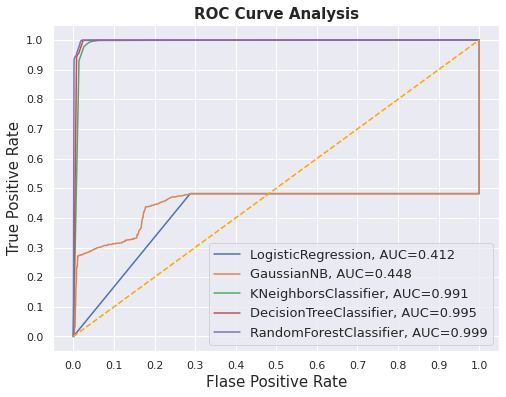

In [27]:
#Plot ROC Curves.
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

As we can see Random Forest did the best though it seems to overfit. I will next look at removing my labels and testing some Unsupervised Learning methods on my data.